In [1]:
import random

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines

# Nastavení proměnných

In [2]:
# rozmery prostoru
WORLD_HEIGHT = 100
WORLD_WIDTH = 100

# rozmery vykreslovaneho obrazku
FIG_HEIGHT = 15
FIG_WIDTH = 15

In [3]:
# pocatecni poloha robota
robot_x = 5
robot_y = 5
robot = (robot_x, robot_y)

# pravdepodobnost vygenerovani smeti
garbages_prob = 20

# pozice jednotlivych smeti
garbages = []

In [4]:
# max pocet iteraci
MAX_ITERS = 1000
# max pocet jednotlivych restartu
MAX_RESTARTS = 1000

# Vytvoření světa

In [5]:
# vygenerovani sveta - tj. pozic a mnoztvi jednotlivych smeti
def make_world(start):
    garbages = []
    # make garbages
    for i in range(5, 105, 10):
        for j in range(5, 105, 10):
            rand_num = random.randrange(0, 100)
            if garbages_prob > rand_num:
                if robot != (i, j) and (i, j) not in garbages:
                    garbages.append((i, j))
    garbages = [start] + garbages
    return garbages

In [6]:
# vykresleni sveta
def show_world(garbages, robot, path = None):
    fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT))
    ax.set_axis_off()
    
    # show border
    ax.add_patch(patches.Rectangle((0.001, 0.001), 0.99, 0.99, fill=False))
    
    # show garbades
    for garbage in garbages:
        if garbage != robot:
            ax.add_patch(patches.Circle((garbage[0] / WORLD_WIDTH, garbage[1] / WORLD_HEIGHT), 0.02, color='m'))
    
    # show robot
    ax.add_patch(patches.Wedge(center = (robot[0] / WORLD_WIDTH, robot[1] / WORLD_HEIGHT), r = 0.02, 
                           theta1 = 20, theta2 = 340, color='tab:orange'))
    # show path
    if path:
        path_lines = [path[k:k+2] for k in range(len(path) - 1)]
        for line in path_lines:
            ax.add_line(lines.Line2D((line[0][0] / WORLD_WIDTH, line[1][0] / WORLD_HEIGHT),
                                 (line[0][1] / WORLD_WIDTH, line[1][1] / WORLD_HEIGHT), color='r'))

In [7]:
def heuristics(a, b):
    return ((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2) ** 0.5

# vypocitani delky reseni
def count_distances(garbages):
    distances = []
    for garbage in garbages:
        garbage_dist = []
        for item in garbages:
            garbage_dist.append(heuristics(garbage, item))
        distances.append(garbage_dist)
    return distances

# pomocna fce
def set_garbage_indexes(garbages):
    garbage_indexes = dict()
    index = 0
    for garbage in garbages:
        garbage_indexes[garbage] = index
        index += 1
    return garbage_indexes

# Hledání nejkratší cesty

In [8]:
# ucelova funkce
def route_length(garbage_indexes, distances, route):
    length = 0
    places_n = len(route)
    for i in range(1, places_n):
        length += distances[garbage_indexes[route[i - 1]]][garbage_indexes[route[i]]]
    return length

# fce pro generovani random reseni
def random_solution(garbages, start):
    solution = []
    for garbage in garbages:
        if garbage != start:
            solution.append(garbage)
    random.shuffle(solution)
    solution = [start] + solution
    return solution

# vraci vsechna sousedni reseni
# tj. takove cesty, kde jsou prohozeny max 2 smeti
def get_neighbours(solution):
    neighbours = []
    solution_l = len(solution)

    for i in range(1, solution_l - 1):
        for j in range(i + 1, solution_l):
            neighbour = []
            for garbage in solution:
                neighbour.append(garbage)
            neighbour[i] = solution[j]
            neighbour[j] = solution[i]
            neighbours.append(neighbour)
    return neighbours

# takovy soused jehoz vzdalenost je nejmensi
def get_best_neighbour(neighbours, distances, garbage_indexes):
    if not neighbours:
        return None, None
    best_length = route_length(garbage_indexes, distances, neighbours[0])
    best_neighbour = neighbours[0]
    
    for neighbour in neighbours:
        current_length = route_length(garbage_indexes, distances, neighbour)
        if current_length < best_length:
            best_length = current_length
            best_neighbour = neighbour
    return best_neighbour, best_length

In [9]:
def hill_climbing(garbages, garbage_indexes, distances, start):
    if len(garbages) == 2:
        return garbages
    solution = random_solution(garbages, start)
    solution_l = route_length(garbage_indexes, distances, solution)
    neighbours = get_neighbours(solution)
    
    best_neighbour, best_length = get_best_neighbour(neighbours, distances, garbage_indexes)
    
    i = 0
    while i < MAX_ITERS and best_length < solution_l:
        i += 1
        solution, solution_l = best_neighbour, best_length
        neighbours = get_neighbours(solution)
        best_neighbour, best_length = get_best_neighbour(neighbours, distances, garbage_indexes)
    
    return solution, solution_l

# unik z lok minima
def local_extreme_escape(garbages, garbage_indexes, distances, start):
    if len(garbages) == 2:
        return garbages
    best_solution = random_solution(garbages, start)
    best_length = route_length(garbage_indexes, distances, best_solution)

    i = 0
    while i < MAX_RESTARTS:
        solution, solution_l = hill_climbing(garbages, garbage_indexes, distances, start)
        if solution_l < best_length:
            best_solution, best_length = solution, solution_l
        i += 1
    return best_solution

# Ukázka

In [10]:
# vytvorreni smeti
garbages = make_world(robot)

# pomocne promennne
garbage_indexes = set_garbage_indexes(garbages)
distances = count_distances(garbages)
print(garbages)

[(5, 5), (5, 15), (15, 25), (25, 5), (25, 45), (25, 65), (25, 75), (25, 85), (35, 65), (35, 95), (45, 65), (55, 5), (55, 95), (65, 5), (65, 25), (65, 65), (75, 65), (75, 75), (85, 5), (85, 35), (95, 5), (95, 25), (95, 45), (95, 65), (95, 75), (95, 95)]


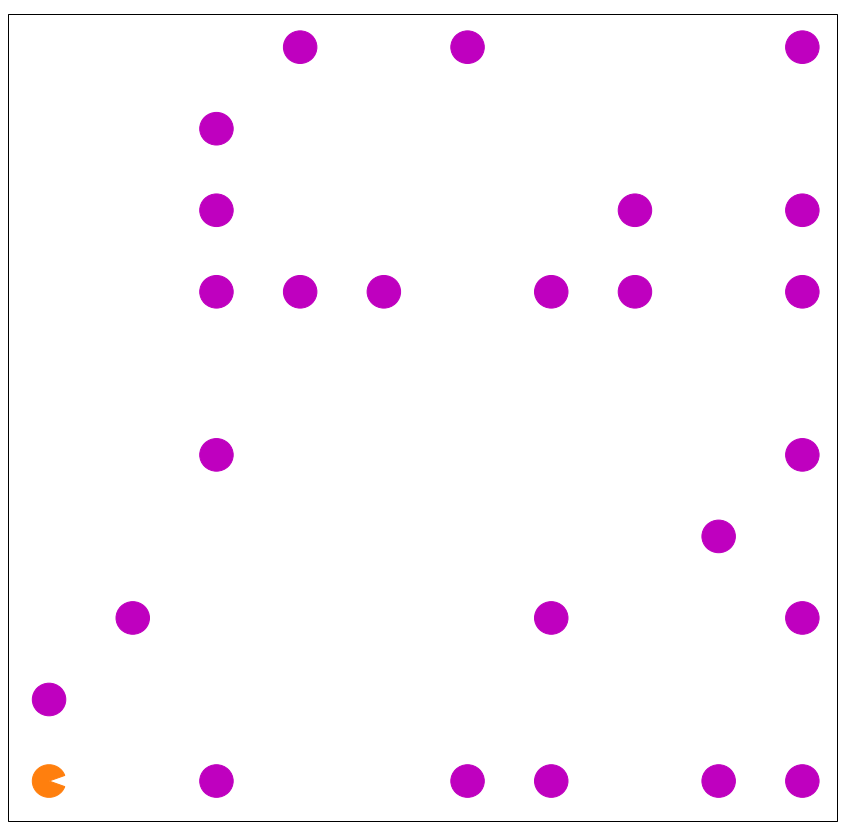

In [11]:
# ukazka vygenerovaneho sveta
show_world(garbages, robot)

In [12]:
# nasle reseni
solution = local_extreme_escape(garbages, garbage_indexes, distances, robot)
print(solution)
print(route_length(garbage_indexes, distances, solution))

[(5, 5), (5, 15), (25, 5), (15, 25), (25, 45), (45, 65), (35, 65), (25, 65), (25, 75), (25, 85), (35, 95), (55, 95), (65, 65), (75, 65), (75, 75), (95, 95), (95, 75), (95, 65), (95, 45), (85, 35), (65, 25), (55, 5), (65, 5), (85, 5), (95, 5), (95, 25)]
428.278989219059


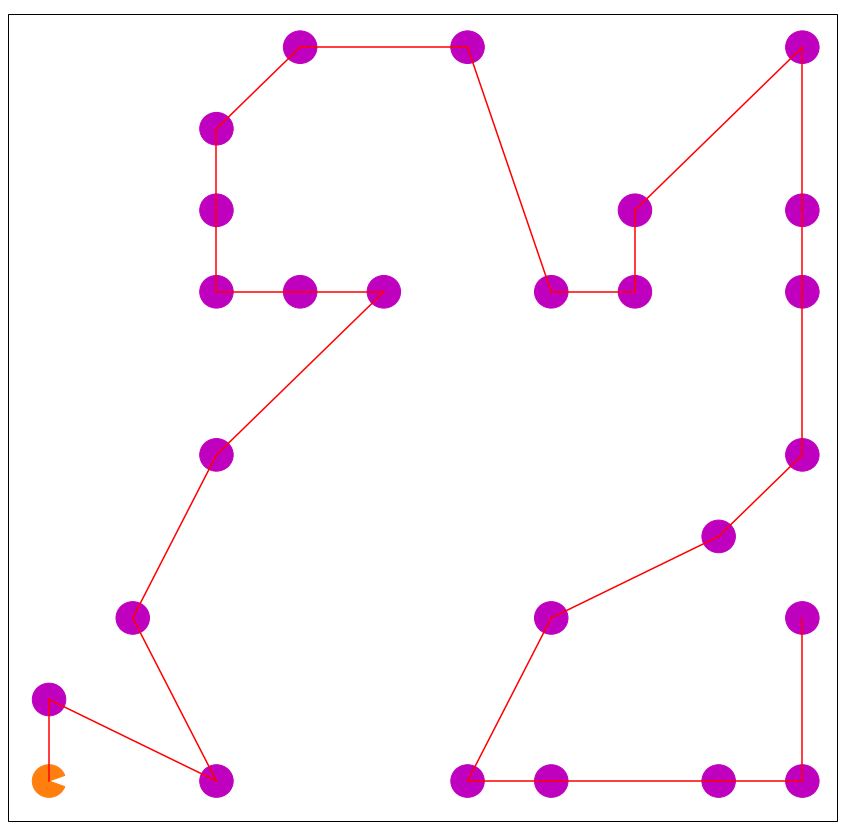

In [13]:
# ukazka nasleho reseni
show_world(garbages, robot, solution)